In [0]:
import numpy as np

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [0]:
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# **PCA via SVD**

In [0]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

# The first two principal components
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [8]:
m, n = X.shape

# S = diagonal matrix of singular values, having same shape as X
S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

np.allclose(X_centered, np.dot(U, np.dot(S, Vt)))

True

In [0]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

# **PCA via Scikit-Learn**

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [11]:
X2D[:5, :]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [12]:
X2D_using_svd[:5, :]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [13]:
np.allclose(X2D, -X2D_using_svd)

True

# **The Inverse Transform and Data Plots**

In [14]:
X3D_inv = pca.inverse_transform(X2D)

np.allclose(X3D_inv, X)

False

In [0]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :]) + pca.mean_

In [16]:
np.allclose(X3D_inv, X3D_inv_using_svd)

True

In [0]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [0]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

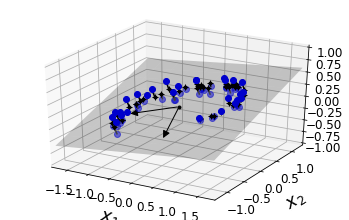

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

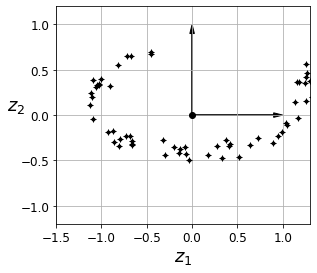

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

plt.show()

# **Explained Variance Ratio and Dimension Choice**

In [22]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [0]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [0]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [28]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

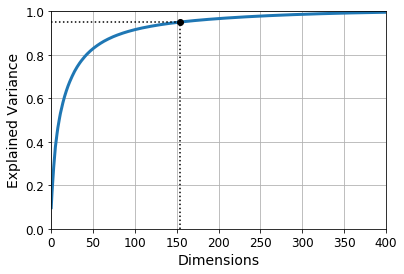

In [29]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.grid(True)

plt.show()

In [0]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [31]:
pca.n_components_

154

In [0]:
X_recovered = pca.inverse_transform(X_reduced)

In [0]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

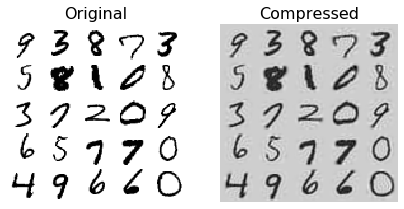

In [34]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.show()

# **Kernel PCA**

In [0]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

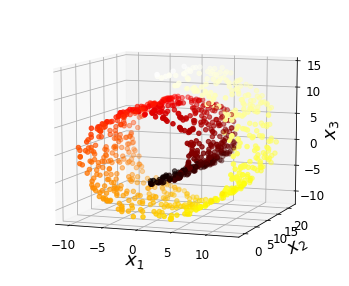

In [39]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

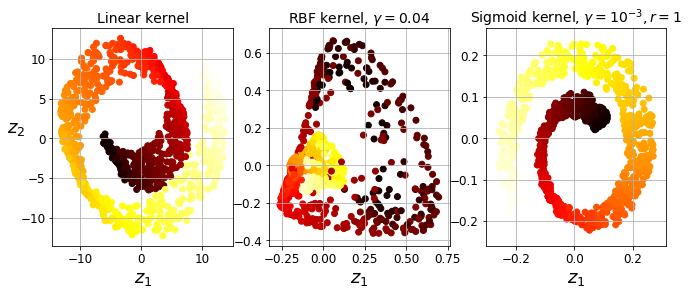

In [40]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

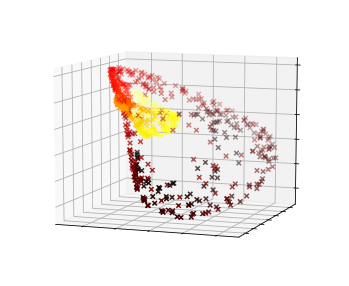

In [41]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()